# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 7
# LDA/QDA and Decision Trees

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately): Walter Thornton, Dwayne Kennemore

Enrollment Status (109A, 121A, 209A, or E109A): E109A

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.svm import LinearSVC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
#import pydotplus
#import io
from sklearn.tree import export_graphviz
from sklearn.preprocessing import PolynomialFeatures
from IPython.display import Image
from IPython.display import display
%matplotlib inline


## Multiclass Thyroid Classification

In this problem, you will build a model for diagnosing disorders in a patient's thyroid gland. Given the results of medical tests on a patient, the task is to classify the patient either as:
- *normal* (class 1)
- having *hyperthyroidism* (class 2)
- or having *hypothyroidism* (class 3). 

The data set is provided in the file `hw7_dataset.csv`. Columns 1-2 contain biomarkers for a patient (predictors):
- Biomarker 1: (Logarithm of) level of basal thyroid-stimulating hormone (TSH) as measured by radioimmuno assay
- Biomarker 2: (Logarithm of) maximal absolute difference of TSH value after injection of 200 micro grams of thyrotropin-releasing hormone as compared to the basal value.

The last column contains the diagnosis for the patient from a medical expert. This data set was obtained from the UCI machine learning repository.

Notice that unlike previous exercises, the task at hand is a 3-class classification problem. We will explore the use of different methods for multiclass classification.

First task: split the data using the following code:

In [2]:
np.random.seed(9001)
df = pd.read_csv('hw7_dataset.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

## Question 1: Fit Classification Models

1. Generate a 2D scatter plot of the training set, denoting each class with a different color. Does it appear that the data points can be separated well by a linear classifier?

2. Briefly explain the difference between multinomial logistic regression and one-vs-rest (OvR) logistic regression methods for fitting a multiclass classifier (in 2-3 sentences).

3. Fit linear classification models on the thyroid data set using both the methods.  You should use $L_2$ regularization in both cases, tuning the regularization parameter using cross-validation.  Is there a difference in the overall classification accuracy of the two methods on the training and test sets?

4. Also, compare the training and test accuracies of these models with the following classification methods:
    - Multiclass Logistic Regression with quadratic terms 
    - Linear Discriminant Analysis
    - Quadratic Discriminant Analysis
    - k-Nearest Neighbors
    <br>
*Note:* you may use either the OvR or multinomial variant for the multiclass logistic regression (with $L_2$ regularization). Do not forget to use cross-validation to choose the regularization parameter, and also the number of neighbors in k-NN. 

5. Does the inclusion of the polynomial terms in logistic regression yield better test accuracy compared to the model with only linear terms? 


*Hint:* You may use the `KNeighborsClassifier` class to fit a k-NN classification model.

Analysis

It looks as if the datapoints can be seperated by a linear classifier. A true multinomial classifier 
predicts directly into multiple categories where a OvR uses a classifier for each predicted category, 
that category being labeled positive with all other classes negative. The actual predicted class is the highest of the 
predicted confidence intervals for each class.

The true multinomial logistic classifier seemed to outperform the OvR method on both the test and train sets, although 
only by a very small margin. The QDA and LDA had the same training score, yet the QDA scored slightly lower on the
test set indicating that the true line is linear. The quadratic classifier leads to slight overfitting. Also of note 
are the logistic models with poly terms. Inclusion of poly terms seems to increase both the train and test set up to degree 3, 
after which no further improvement occurs.
KNN's best value of k was three. Though this scored high on the train set, it overfit the model showing a 6.5% reduction from
train to test. With these models, the best performing model, using classification score as the metric, the
True Multinomial Logistic with poly, degree=3 model scored the highest with an 89.3% accuracy rate. Inclusion of these 
polynomial terms does increase test performance.


In [13]:
data_train.head()

,Biomarker 1,Biomarker 2,Diagnosis
0,0.262372,0.875473,1.0
5,0.336479,1.098616,1.0
9,0.182330,-1.609488,2.0
12,-0.223131,0.788462,1.0
13,0.587792,1.458617,1.0


C:\Users\wlt42\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
C:\Users\wlt42\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


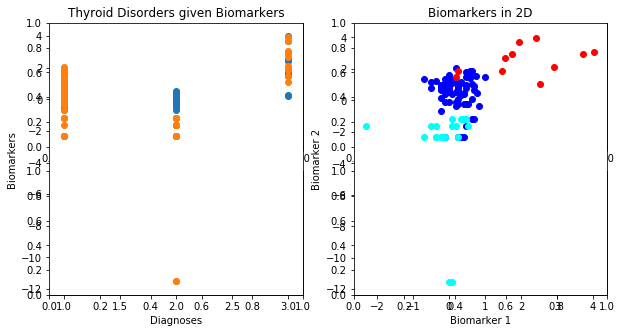

In [14]:
def leppard(source_data, prediction_data, min_domain, max_domain):
    #print ("Comparing - ", source_data, " and ", prediction_data)
    running_tally = 0
    print("   ", end="")
    for w in range (min_domain, max_domain + 1):
        print (w, "  ", end="")
    print()
    for x in range(min_domain, max_domain + 1):
        print(x, " ", end="")
        for y in range(min_domain, max_domain + 1):
            for result in range(0, len(prediction_data)):
                if int(prediction_data[result]) == x and int(source_data[result]) == y:
                    running_tally += 1

            print (running_tally, " ", end="")
        print()

factors = ['Biomarker 1', 'Biomarker 2']

plt.clf()
fig, ax = plt.subplots(2, 2, figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

y = data_train['Diagnosis']
y = y.reshape(-1, 1)

for i, k in enumerate(factors):
        
    x = data_train[k]
    x = x.reshape(-1, 1)
    
      
    # Build graph
    ax1.scatter(y, x)
    ax1.set_xlabel("Diagnoses")
x1 = data_train[['Biomarker 1']].values
x2 = data_train[['Biomarker 2']].values
   

ax1.set_ylabel('Biomarkers')
ax1.set_title('Thyroid Disorders given Biomarkers')

ax2.scatter(x1[y==1], x2[y==1], c='blue', cmap=plt.cm.coolwarm)
ax2.scatter(x1[y==2], x2[y==2], c='cyan', cmap=plt.cm.coolwarm)
ax2.scatter(x1[y==3], x2[y==3], c='red', cmap=plt.cm.coolwarm)
ax2.set_xlabel('Biomarker 1')
ax2.set_ylabel('Biomarker 2')
ax2.set_title('Biomarkers in 2D')

In [15]:


y_train = data_train['Diagnosis'].values
X_train = data_train[['Biomarker 1', 'Biomarker 2']].values
y_train = y_train.reshape(len(y_train), 1)

y_test = data_test['Diagnosis'].values
X_test = data_test[['Biomarker 1', 'Biomarker 2']].values
y_test = y_test.reshape(len(y_test), 1)

In [16]:
# knn classification
knn = KNeighborsClassifier(n_neighbors=k)
neigbors = {'n_neighbors':range(1,80)}
clf = GridSearchCV(knn, neigbors, cv=5, n_jobs=4)
clf.fit(X_train, y_train.flatten(y_train.tolist()))
knn_best = clf.best_estimator_
print ('The classifier had the best CrossValidated score of:', clf.best_score_)
print('with best k::', clf.best_params_) 
print ('The classifier had a Train score of:', knn_best.score(X_train,y_train))
print ('The classifier had a Test score of:', knn_best.score(X_test,y_test))
print('The confusion matrix is:')
print(confusion_matrix(y_test,knn_best.predict(X_test)))


C:\Users\wlt42\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  """


The classifier had the best CrossValidated score of: 0.901960784314
with best k:: {'n_neighbors': 3}
The classifier had a Train score of: 0.93137254902
The classifier had a Test score of: 0.867256637168
The confusion matrix is:
[[71  5  1]
 [ 5 12  0]
 [ 4  0 15]]


In [44]:
# QDA classification

clf = QuadraticDiscriminantAnalysis(store_covariances=True)
clf.fit(X_train, y_train.flatten(y_train.tolist()))

print ('The classifier had a Train score of:', clf.score(X_train,y_train))
print ('The classifier had a Test score of:', clf.score(X_test,y_test))
print('The confusion matrix is:')
print(confusion_matrix(y_test,clf.predict(X_test)))


The classifier had a Train score of: 0.872549019608
The classifier had a Test score of: 0.849557522124
The confusion matrix is:
[[71  5  1]
 [ 7 10  0]
 [ 4  0 15]]


C:\Users\wlt42\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  after removing the cwd from sys.path.


In [18]:
# LDA classification
lda = LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None, solver='svd', store_covariance=False, tol=0.0001)
lda.fit(X_train, y_train.flatten(y_train.tolist()))
print ('The classifier had a Train score of:', lda.score(X_train,y_train))
print ('The classifier had a Test score of:', lda.score(X_test,y_test))
print('The confusion matrix is:')
print(confusion_matrix(y_test,lda.predict(X_test)))

The classifier had a Train score of: 0.872549019608
The classifier had a Test score of: 0.83185840708
The confusion matrix is:
[[74  3  0]
 [12  5  0]
 [ 4  0 15]]


C:\Users\wlt42\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
# True Multinomial Logistic classification
mnl = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, 
                        intercept_scaling=1, class_weight=None, random_state=None, solver='newton-cg',
                        max_iter=100, multi_class='multinomial', verbose=0, warm_start=False, n_jobs=4)
C = {'C':(0.1, 1, 10, 100, 1000, 10000, 100000,)}
clf = GridSearchCV(mnl, C, cv=5, n_jobs=4)
clf.fit(X_train, y_train.flatten(y_train.tolist()))
mnl_best = clf.best_estimator_
print ('The classifier had the best CrossValidated score of:', clf.best_score_)
print('with alpha:', clf.best_params_) 
print ('The classifier had a Train score of:', mnl_best.score(X_train,y_train))
print ('The classifier had a Test score of:', mnl_best.score(X_test,y_test))
print('The confusion matrix is:')
print(confusion_matrix(y_test,mnl_best.predict(X_test)))


C:\Users\wlt42\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  import sys


The classifier had the best CrossValidated score of: 0.852941176471
with alpha: {'C': 10}
The classifier had a Train score of: 0.892156862745
The classifier had a Test score of: 0.884955752212
The confusion matrix is:
[[72  4  1]
 [ 6 11  0]
 [ 2  0 17]]


In [34]:
# OvR Logistic classification
ovr = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, 
                        intercept_scaling=1, class_weight=None, random_state=None, solver='newton-cg',
                        max_iter=100, multi_class='ovr', verbose=0, warm_start=False, n_jobs=4)
C = {'C':(0.1, 1, 10, 100, 1000, 10000, 100000,)}
clf = GridSearchCV(ovr, C, cv=5, n_jobs=4)
clf.fit(X_train, y_train.flatten(y_train.tolist()))
ovr_best = clf.best_estimator_
print ('The classifier had the best CrossValidated score of:', clf.best_score_)
print('with alpha:', clf.best_params_) 
print ('The classifier had a Train score of:', ovr_best.score(X_train,y_train))
print ('The classifier had a Test score of:', ovr_best.score(X_test,y_test))
print('The confusion matrix is:')
print(confusion_matrix(y_test,ovr_best.predict(X_test)))

C:\Users\wlt42\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  import sys


The classifier had the best CrossValidated score of: 0.823529411765
with alpha: {'C': 10}
The classifier had a Train score of: 0.872549019608
The classifier had a Test score of: 0.867256637168
The confusion matrix is:
[[74  3  0]
 [ 8  9  0]
 [ 4  0 15]]


In [21]:
# True Multinomial Logistic classification with polynomial terms to degree=2
gen_poly_terms = PolynomialFeatures(degree=2)
X_train_with_poly_2 = gen_poly_terms.fit_transform(X_train)
X_test_with_poly_2 = gen_poly_terms.fit_transform(X_test)
poly_regression_model = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, 
                        intercept_scaling=1, class_weight=None, random_state=None, solver='newton-cg',
                        max_iter=100, multi_class='multinomial', verbose=0, warm_start=False, n_jobs=4)
poly_best = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, 
                        intercept_scaling=1, class_weight=None, random_state=None, solver='newton-cg',
                        max_iter=100, multi_class='multinomial', verbose=0, warm_start=False,
                        n_jobs=4).fit(X_train_with_poly_2, y_train.flatten(y_train.tolist()))
C = {'C':(0.1, 1, 10, 100, 1000, 10000, 100000,)}
clf = GridSearchCV(poly_regression_model, C, cv=5, n_jobs=4)
clf.fit(X_train_with_poly_2, y_train.flatten(y_train.tolist()))
poly2_best = clf.best_estimator_
print ('The classifier had the best CrossValidated score of:', clf.best_score_)
print('with C and n degrees:', clf.best_params_) 
print ('The classifier had a Train score of:', poly_best.score(X_train_with_poly_2,y_train))
print ('The classifier had a Test score of:', poly_best.score(X_test_with_poly_2,y_test))
print('The confusion matrix is:')
print(confusion_matrix(y_test,poly_best.predict(X_test_with_poly_2)))





C:\Users\wlt42\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  # This is added back by InteractiveShellApp.init_path()
C:\Users\wlt42\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  


The classifier had the best CrossValidated score of: 0.872549019608
with C and n degrees: {'C': 1}
The classifier had a Train score of: 0.882352941176
The classifier had a Test score of: 0.884955752212
The confusion matrix is:
[[73  4  0]
 [ 6 11  0]
 [ 3  0 16]]


In [22]:
# True Multinomial Logistic classification with polynomial terms to degree=3
gen_poly_terms = PolynomialFeatures(degree=3)
X_train_with_poly_3 = gen_poly_terms.fit_transform(X_train)
X_test_with_poly_3 = gen_poly_terms.fit_transform(X_test)
poly_regression_model = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, 
                        intercept_scaling=1, class_weight=None, random_state=None, solver='newton-cg',
                        max_iter=100, multi_class='multinomial', verbose=0, warm_start=False, n_jobs=4)
poly3_best = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True, 
                        intercept_scaling=1, class_weight=None, random_state=None, solver='newton-cg',
                        max_iter=100, multi_class='multinomial', verbose=0, warm_start=False,
                        n_jobs=4).fit(X_train_with_poly_3, y_train.flatten(y_train.tolist()))
C = {'C':(0.1, 1, 10, 100, 1000, 10000, 100000,)}
clf = GridSearchCV(poly_regression_model, C, cv=5, n_jobs=4)
clf.fit(X_train_with_poly_3, y_train.flatten(y_train.tolist()))
poly3_best = clf.best_estimator_
print ('The classifier had the best CrossValidated score of:', clf.best_score_)
print('with C and n degrees:', clf.best_params_) 
print ('The classifier had a Train score of:', poly3_best.score(X_train_with_poly_3,y_train))
print ('The classifier had a Test score of:', poly3_best.score(X_test_with_poly_3,y_test))
print('The confusion matrix is:')
print(confusion_matrix(y_test,poly3_best.predict(X_test_with_poly_3)))


C:\Users\wlt42\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  # This is added back by InteractiveShellApp.init_path()
C:\Users\wlt42\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  


The classifier had the best CrossValidated score of: 0.892156862745
with C and n degrees: {'C': 10}
The classifier had a Train score of: 0.93137254902
The classifier had a Test score of: 0.893805309735
The confusion matrix is:
[[72  4  1]
 [ 5 12  0]
 [ 2  0 17]]


In [23]:
# True Multinomial Logistic classification with polynomial terms to degree=4
gen_poly_terms = PolynomialFeatures(degree=4)
X_train_with_poly_4 = gen_poly_terms.fit_transform(X_train)
X_test_with_poly_4 = gen_poly_terms.fit_transform(X_test)
poly_regression_model = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, 
                        intercept_scaling=1, class_weight=None, random_state=None, solver='newton-cg',
                        max_iter=100, multi_class='multinomial', verbose=0, warm_start=False, n_jobs=4)
poly4_best = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, 
                        intercept_scaling=1, class_weight=None, random_state=None, solver='newton-cg',
                        max_iter=100, multi_class='multinomial', verbose=0, warm_start=False,
                        n_jobs=4).fit(X_train_with_poly_4, y_train.flatten(y_train.tolist()))
C = {'C':(0.1, 1, 10, 100, 1000, 10000, 100000,)}
clf = GridSearchCV(poly_regression_model, C, cv=5, n_jobs=4)
clf.fit(X_train_with_poly_4, y_train.flatten(y_train.tolist()))
poly4_best = clf.best_estimator_
print ('The classifier had the best CrossValidated score of:', clf.best_score_)
print('with C and n degrees:', clf.best_params_) 
print ('The classifier had a Train score of:', poly4_best.score(X_train_with_poly_4,y_train))
print ('The classifier had a Test score of:', poly4_best.score(X_test_with_poly_4,y_test))
print('The confusion matrix is:')
print(confusion_matrix(y_test,poly4_best.predict(X_test_with_poly_4)))


C:\Users\wlt42\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  # This is added back by InteractiveShellApp.init_path()
C:\Users\wlt42\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  


The classifier had the best CrossValidated score of: 0.872549019608
with C and n degrees: {'C': 1}
The classifier had a Train score of: 0.921568627451
The classifier had a Test score of: 0.893805309735
The confusion matrix is:
[[72  4  1]
 [ 5 12  0]
 [ 2  0 17]]


## Question 2: Visualize Decision Boundaries

The following code will allow you to visualize the decision boundaries of a given classification model.

In [24]:
#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (the classifier you want to visualize)
#      title (title for plot)
#      ax (a set of axes to plot on)
#      poly_degree (highest degree of polynomial terms included in the model; None by default)

def plot_decision_boundary(x, y, model, title, ax, poly_degree=None):
    # Create mesh
    # Interval of points for biomarker 1
    min0 = x[:,0].min()
    max0 = x[:,0].max()
    interval0 = np.arange(min0, max0, (max0-min0)/100)
    n0 = np.size(interval0)
    
    # Interval of points for biomarker 2
    min1 = x[:,1].min()
    max1 = x[:,1].max()
    interval1 = np.arange(min1, max1, (max1-min1)/100)
    n1 = np.size(interval1)

    # Create mesh grid of points
    x1, x2 = np.meshgrid(interval0, interval1)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh of points
    # Check if polynomial terms need to be included
    if(poly_degree!=None):
        # Use PolynomialFeatures to generate polynomial terms
        poly = PolynomialFeatures(poly_degree)
        xx_ = poly.fit_transform(xx)
        yy = model.predict(xx_) 
    else:   
        yy = model.predict(xx)
        
    yy = yy.reshape((n0, n1))

    # Plot decision surface
    x1 = x1.reshape(n0, n1)
    x2 = x2.reshape(n0, n1)
    ax.contourf(x1, x2, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    
    # Plot scatter plot of data
    yy = y.reshape(-1,)
    ax.scatter(x[yy==1,0], x[yy==1,1], c='blue', label='Normal', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==2,0], x[yy==2,1], c='cyan', label='Hyper', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==3,0], x[yy==3,1], c='red', label='Hypo', cmap=plt.cm.coolwarm)
    
    # Label axis, title
    ax.set_title(title)
    ax.set_xlabel('Biomarker 1')
    ax.set_ylabel('Biomarker 2')

C:\Users\wlt42\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wlt42\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


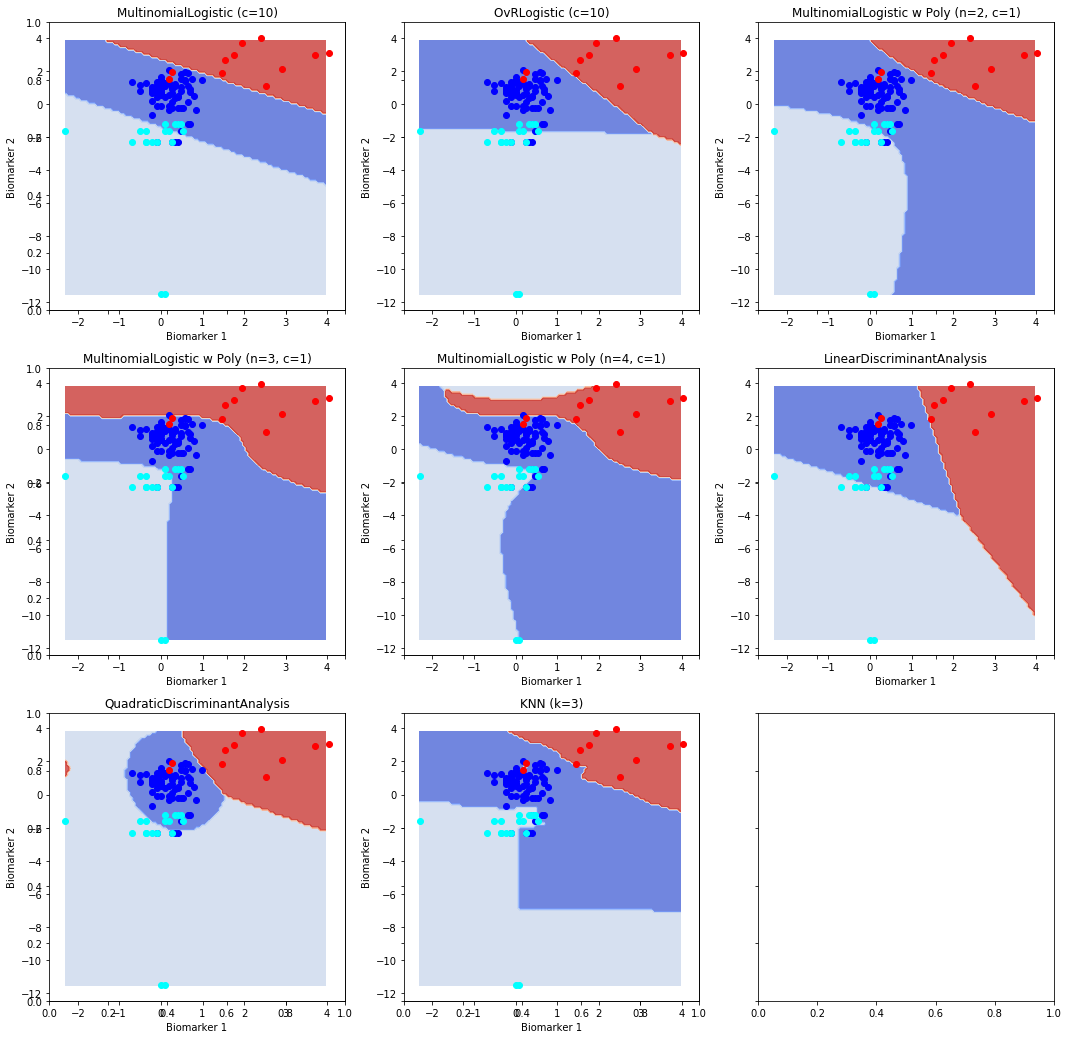

In [25]:
plt.clf()
fig, ax = plt.subplots(3, 3, sharey=True, sharex=True, figsize=(18, 18))
ax1 = fig.add_subplot(331)
ax2 = fig.add_subplot(332)
ax3 = fig.add_subplot(333)
ax4 = fig.add_subplot(334)
ax5 = fig.add_subplot(335)
ax6 = fig.add_subplot(336)
ax7 = fig.add_subplot(337)
ax8 = fig.add_subplot(338)


plot_decision_boundary(X_train, y_train, LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True, 
                        intercept_scaling=1, class_weight=None, random_state=None, solver='newton-cg',
                        max_iter=100, multi_class='multinomial', verbose=0, warm_start=False, n_jobs=4).fit(X_train, y_train), "MultinomialLogistic (c=10)", ax1, poly_degree=None)
plot_decision_boundary(X_train, y_train, LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True, 
                        intercept_scaling=1, class_weight=None, random_state=None, solver='newton-cg',
                        max_iter=100, multi_class='ovr', verbose=0, warm_start=False, n_jobs=4).fit(X_train, y_train), "OvRLogistic (c=10)", ax2, poly_degree=None)
plot_decision_boundary(X_train, y_train, LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, 
                        intercept_scaling=1, class_weight=None, random_state=None, solver='newton-cg',
                        max_iter=100, multi_class='multinomial', verbose=0, warm_start=False, n_jobs=4).fit(X_train_with_poly_2, y_train), "MultinomialLogistic w Poly (n=2, c=1)", ax3, poly_degree=2) 

plot_decision_boundary(X_train, y_train, LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, 
                        intercept_scaling=1, class_weight=None, random_state=None, solver='newton-cg',
                        max_iter=100, multi_class='multinomial', verbose=0, warm_start=False, n_jobs=4).fit(X_train_with_poly_3, y_train), "MultinomialLogistic w Poly (n=3, c=1)", ax4, poly_degree=3)                       


plot_decision_boundary(X_train, y_train, LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, 
                        intercept_scaling=1, class_weight=None, random_state=None, solver='newton-cg',
                        max_iter=100, multi_class='multinomial', verbose=0, warm_start=False, n_jobs=4).fit(X_train_with_poly_4, y_train), "MultinomialLogistic w Poly (n=4, c=1)", ax5, poly_degree=4)                       


plot_decision_boundary(X_train, y_train, LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None, solver='svd', store_covariance=False, tol=0.0001).fit(X_train, y_train), "LinearDiscriminantAnalysis", ax6, poly_degree=None)
plot_decision_boundary(X_train, y_train, QuadraticDiscriminantAnalysis(reg_param=0.0, store_covariances=True).fit(X_train, y_train), "QuadraticDiscriminantAnalysis", ax7, poly_degree=None)
plot_decision_boundary(X_train, y_train, KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train), "KNN (k=3)", ax8, poly_degree=None)


**Note:** The provided code uses `sklearn`'s `PolynomialFeatures` to generate higher-order polynomial terms, with degree `poly_degree`. 
Also, if you have loaded the data sets into `pandas` data frames, you may use the `as_matrix` function to obtain a `numpy` array from the data frame objects.

1. Use the above code to visualize the decision boundaries for each of the model fitted in the previous part.
2. Comment on the difference in the decision boundaries (if any) for the OvR and multinomial logistic regression models. Is there a difference between the decision boundaries for the linear logistic regression models and LDA. What about the decision boundaries for the quadratic logistic regression and QDA? Give an explanation for your answer.

Analysis

The visible difference between multinomial and Ovr is that the multinomial decision bounds seem parallel over our space.
This seems to fit in with the idea of multinomial as trult multiclass, whereas the OvR bounds meet. The OvR logistic is very 
similar to the LDA with straight lines as the decision boundaries. Both QDA and the poly terms both demonstrate the flexibility 
of there boundaries, with curved lines as ther boundaries. 

## Question 3: Fit Decision Trees

We next try out decision trees for thyroid classification. For the following questions, you may use the *Gini* index as the splitting criterion while fitting the decision tree. 
1. Fit a decision tree model to the thyroid data set with (maximum) tree depths 2, 3, ..., 10. Make plots of the training and test accuracies as a function of the tree depth. Is there a depth at which the fitted decision tree model achieves near-perfect classification on the training set? If so, what can you say about the test accuracy of this model?

2. Use 5-fold cross-validation to find the optimal tree depth. How does the performance of a decision tree fitted with this depth compare with the models fitted in Part 2(a)?

3. Use the code provided in Part 2(c) to visualize the decision boundary of the fitted decision tree. How is the decision boundary of the decision tree model different from the other methods? Given an explanation for your observation.

4. Use the `export_graphviz` function in `sklearn` to generate a visualization of the tree diagram for the fitted model. Based on the visualization, explain *in words* how the fitted model diagnoses 'hypothyroidism' for a patient.  


Analysis

At depth 7 the decision tree attains near perfect accuracy on the training set, however, after a depth of 4, the model overfits and testing accuracy goes down. Interestingly cross validation picks our best depth at 3, while actually plotting the accuracy as a function of depth shows that we achieve the highest test accuracy as a level of 4. Perhaps this is a byproduct of having a small dataset.
The shape of the boundaries is unique in that is a number of intersecting lines each representing a binary decision, these creat edges and corners in the visualization as the decision tree captures what other models cant. Althoung for this dataset, the decision tree scored close to the previos models, actually tying in accuracy on the test set with the multinomial model of degree two. We can see how this type of model may be suited for particular datasets but on our particular set it was not as good as the multinomial models and a bit better than QDA and LDA. How this model 'decides' can be seen in the visualized decision tree. Each decision in the tree is a level, with the outcome of each decision represented as a node in the tree. Finally, on the lowest layer, each leaf refers to a particular classification, the outcome of a series of binary decisions.

C:\Users\wlt42\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead


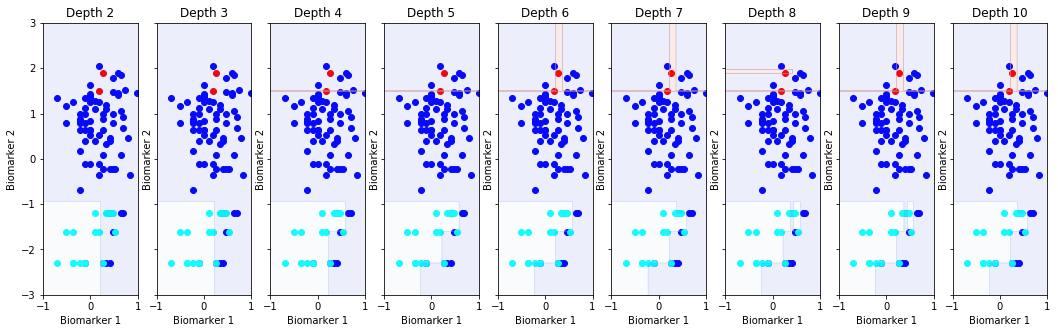

In [26]:
def fit_and_plot_dt(x, y, depth, title, ax, plot_data=True, fill=True, color='Greens'):
    # FIT DECISION TREE MODEL
    dt = tree.DecisionTreeClassifier(max_depth = depth)
    dt.fit(x, y)

    # PLOT DECISION TREE BOUNDARY
    ax = plot_tree_boundary(x, y, dt, title, ax, plot_data, fill, color)
    
    return ax


def plot_tree_boundary(x, y, model, title, ax, plot_data=True, fill=True, color='Greens'):
    if plot_data:
        # PLOT DATA
        ax.scatter(x[y==1,0], x[y==1,1], c='blue', cmap=plt.cm.coolwarm)
        ax.scatter(x[y==2,0], x[y==2,1], c='cyan', cmap=plt.cm.coolwarm)
        ax.scatter(x[y==3,0], x[y==3,1], c='red', cmap=plt.cm.coolwarm)
    # CREATE MESH
    interval = np.arange(min(x.min(), y.min()),max(x.max(), y.max()),0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # PREDICT ON MESH POINTS
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # PLOT DECISION SURFACE
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    if fill:
        ax.contourf(x1, x2, yy, alpha=0.1, cmap=plt.cm.coolwarm)
    else:
        ax.contour(x1, x2, yy, alpha=0.1, cmap=plt.cm.coolwarm)
    
    # LABEL AXIS, TITLE
    ax.set_title(title)
    ax.set_xlabel('Biomarker 1')
    ax.set_ylabel('Biomarker 2')
    
    return ax

depths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
fig, ax = plt.subplots(1, len(depths), figsize=(18, 5), sharey=True, sharex=True)
x = X_train
y = y_train.flatten(y_train.tolist())
ind = 0
for i in depths:
    ax[ind] = fit_and_plot_dt(x, y, i, 'Depth {}'.format(i), ax[ind]) 
    ax[ind].set_xlim(-1, 1)
    ax[ind].set_ylim(-3, 3)
    ind += 1
    


C:\Users\wlt42\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


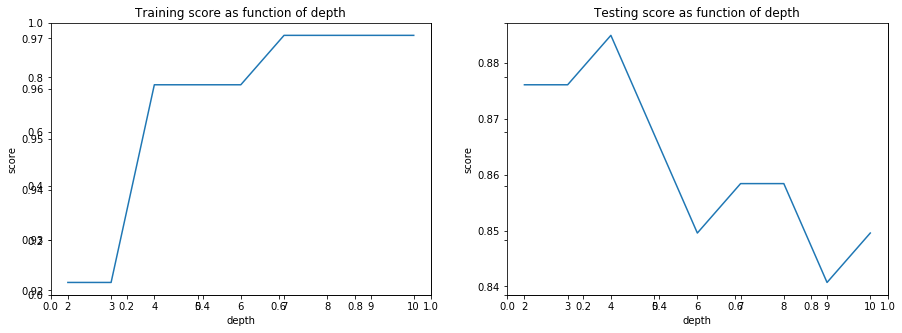

In [27]:
#Overfitting
fig, ax= plt.subplots(1, 2, figsize=(15, 5), sharey=True)
scores_train = []
scores_test = []
for depth in depths:
    dt = tree.DecisionTreeClassifier(max_depth = depth)
    dt.fit(X_train, y_train)
    scores_train.append(dt.score(X_train, y_train))
ax5 = fig.add_subplot(121)
ax6 = fig.add_subplot(122)    
ax5.set_xlabel('depth')
ax5.set_ylabel('score')
ax5.set_title('Training score as function of depth')
ax5.legend()
ax5.plot(depths, scores_train)

for depth in depths:
    dt = tree.DecisionTreeClassifier(max_depth = depth)
    dt.fit(X_train, y_train)
    scores_test.append(dt.score(X_test, y_test))
    
ax6.set_xlabel('depth')
ax6.set_ylabel('score')
ax6.set_title('Testing score as function of depth')
ax6.legend()
ax6.plot(depths, scores_test)


In [33]:
parameters = {'max_depth':range(2,10)}
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, cv=5, n_jobs=4)
clf.fit(X_train, y_train.flatten(y_train.tolist()))
tree_model = clf.best_estimator_
print ('The classifier had the best CrossValidated score of:', clf.best_score_)
print('at a depth of:', clf.best_params_)
print ('The classifier had a Train score of:', tree_model.score(X_train,y_train))
print ('The classifier had a Test score of:', tree_model.score(X_test,y_test))
print('The confusion matrix is:')
print(confusion_matrix(y_test,tree_model.predict(X_test)))


C:\Users\wlt42\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  This is separate from the ipykernel package so we can avoid doing imports until


The classifier had the best CrossValidated score of: 0.911764705882
at a depth of: {'max_depth': 2}
The classifier had a Train score of: 0.921568627451
The classifier had a Test score of: 0.87610619469
The confusion matrix is:
[[73  3  1]
 [ 6 11  0]
 [ 4  0 15]]


In [43]:
# decision tree with max depth=4
clf = tree.DecisionTreeClassifier( max_depth=4)
tree_model = clf.fit(X_train, y_train.flatten(y_train.tolist()))

print('The classifier had a Train score of:', tree_model.score(X_train,y_train))
print('The classifier had a Test score of:', tree_model.score(X_test,y_test))
print('The confusion matrix is:')
print(confusion_matrix(y_test,tree_model.predict(X_test)))

The classifier had a Train score of: 0.960784313725
The classifier had a Test score of: 0.884955752212
The confusion matrix is:
[[73  3  1]
 [ 5 12  0]
 [ 4  0 15]]


C:\Users\wlt42\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  


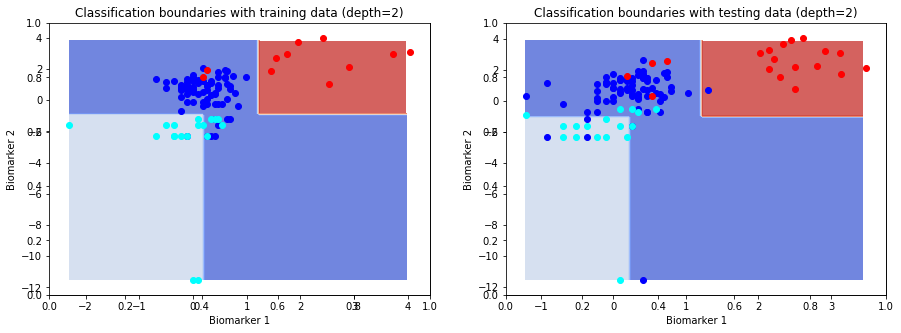

In [29]:
fig, ax= plt.subplots(1, 2, figsize=(15, 5))
 
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
clf = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train)
plot_decision_boundary(X_train, y_train, clf, "Classification boundaries with training data (depth=2)", ax1, poly_degree=None)
plot_decision_boundary(X_test, y_test, clf, "Classification boundaries with testing data (depth=2)", ax2, poly_degree=None)

In [30]:
export_graphviz(clf, out_file='tree.dot') 

<img src="tree_dot.png">

<img src="tree_dot.png">

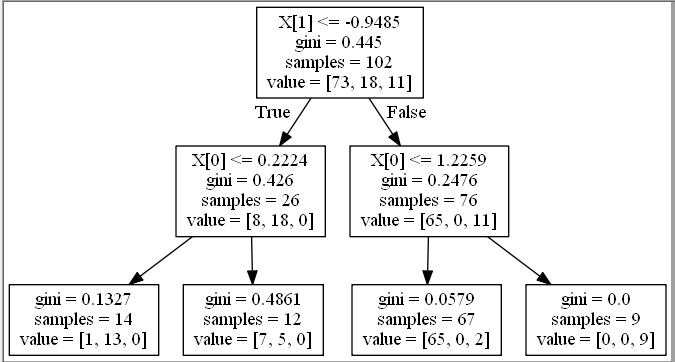

In [31]:
from IPython.display import Image
Image(filename="clf_dot.PNG", width=660, height=660)


*Note:* Look at the `export_graphviz` function in the `sklearn.tree` module. 

You can get a graphic for this visualization by pasting the generated graphviz file in the text box at http://www.webgraphviz.com/ , or you can do it on your own computer.

If you choose the do the latter, you will have to install `GraphViz` and `pydot` to use the decision tree rendering code. For this, you may execute the following commands in a terminal:

`$pip install graphviz`<br>
`$pip install pydot`

*Hint:* You may use the `DecisionTreeClassifier` class to fit a decision tree classifier and the `max_depth` attribute to set the tree depth. You may use the `cross_val_score` function for cross-validation with decision trees.

## Question 4: Too many models to choose from!

We have so far seen six different ways of fitting a classification model for thyroid classification problem: **linear logistic regression**, **logistic regression with polynomial terms**, **LDA**, **QDA**, **k-NN** and **decision tree**. Which of these methods should one use in practice? To answer this question, we now look at the pros and cons of each method.

1. Compare and contrast the six models based on each of the following criteria (a supporting table to summarize your  thoughts can be helpful):
  - Classification performance
  - Complexity of decision boundary
  - Memory storage
  - Ease of interpretability

2. If you were a clinician who had to use the classifier to diagnose thyroid disorders in patients, which among the six methods would you be most comfortable in using? 

Analysis

Decision trees are the easiest to interpret. Each boundary is a simple decision made by the 
model based on some quantitative measure. We can easily visualize this tree and understand the models 'decisions'. The decision tree is also flexible as we increas the depth. Most of our models seem to be fairly easy to interpret only because of the limited number of predictors and thus our ability to visualize the boundaries in two dimensions. 
The flexible models include QDA, logistic with poly, and KNNs with low k's. Our best k was three, and therefor our KNN was very flexible, responding locally to each points three nearest neighbors. This flexibility certainly helped our classification rates particularly with the poly logistic. As you can see from the results below the multinomial logistic model with 3 and 4 terms scored the best, but we would choose 3 degrees, as this achieves both the maximum classification rate while being less complex than models with higher order terms. These additional terms would lead to increased computational complexity. 
If we were clinicians diagnosing thyroid disorders we would choos multinomial logistic with polynomial terms to degree 3. Not only does it have the highest classification accuracy across all models, but it also has the least number of false negatives, there were only 7 patients misclassified as not haveing either form of thyroid problem. In this case, these would be the most costly of the errors, therefore minimizing these false negatives would be a priority in choosing a classification model.

In [ ]:
KNN
The classifier had the best CrossValidated score of: 0.901960784314
with best k:: {'n_neighbors': 3}
The classifier had a Train score of: 0.93137254902
The classifier had a Test score of: 0.867256637168
The confusion matrix is:
[[71  5  1]
 [ 5 12  0]
 [ 4  0 15]]

QDA
The classifier had a Train score of: 0.872549019608
The classifier had a Test score of: 0.849557522124
The confusion matrix is:
[[71  5  1]
 [ 7 10  0]
 [ 4  0 15]]

LDA
The classifier had a Train score of: 0.872549019608
The classifier had a Test score of: 0.83185840708
The confusion matrix is:
[[74  3  0]
 [12  5  0]
 [ 4  0 15]]

True Multinomial Logistic
The classifier had the best CrossValidated score of: 0.852941176471
with alpha: {'C': 10}
The classifier had a Train score of: 0.892156862745
The classifier had a Test score of: 0.884955752212
The confusion matrix is:
[[72  4  1]
 [ 6 11  0]
 [ 2  0 17]]
In [20]:

OvR Logistic
The classifier had the best CrossValidated score of: 0.823529411765
with alpha: {'C': 10}
The classifier had a Train score of: 0.872549019608
The classifier had a Test score of: 0.867256637168
The confusion matrix is:
[[74  3  0]
 [ 8  9  0]
 [ 4  0 15]]

True Multinomial Logistic with poly, degree=2
The classifier had the best CrossValidated score of: 0.872549019608
with C and n degrees: {'C': 1}
The classifier had a Train score of: 0.882352941176
The classifier had a Test score of: 0.884955752212
The confusion matrix is:
[[73  4  0]
 [ 6 11  0]
 [ 3  0 16]]

True Multinomial Logistic with poly, degree=3
The classifier had the best CrossValidated score of: 0.892156862745
with C and n degrees: {'C': 10}
The classifier had a Train score of: 0.93137254902
The classifier had a Test score of: 0.893805309735
The confusion matrix is:
[[72  4  1]
 [ 5 12  0]
 [ 2  0 17]]

True Multinomial Logistic with poly, degree=4
The classifier had the best CrossValidated score of: 0.872549019608
with C and n degrees: {'C': 1}
The classifier had a Train score of: 0.921568627451
The classifier had a Test score of: 0.893805309735
The confusion matrix is:
[[72  4  1]
 [ 5 12  0]
 [ 2  0 17]]

Decision Tree
The classifier had the best CrossValidated score of: 0.911764705882
at a depth of: {'max_depth': 2}
The classifier had a Train score of: 0.921568627451
The classifier had a Test score of: 0.87610619469
The confusion matrix is:
[[73  3  1]
 [ 6 11  0]
 [ 4  0 15]]

Decision Tree with manuall set depth=4
The classifier had a Train score of: 0.960784313725
The classifier had a Test score of: 0.884955752212
The confusion matrix is:
[[73  3  1]
 [ 5 12  0]
 [ 4  0 15]]

## Question 5: Including an 'abstain' option

One of the reasons a hospital might be hesitant to use your thyroid classification model is that a misdiagnosis by the model on a patient can sometimes prove to be very costly (e.g. if the patient were to file a law suit seeking a compensation for damages). One way to mitigate this concern is to allow the model to 'abstain' from making a prediction, whenever it is uncertain about the diagnosis for a patient. However, when the model abstains from making a prediction, the hospital will have to forward the patient to a thyroid specialist (i.e. an endocrinologist), which would incur additional cost. How does one design a thyroid classification model with an abstain option, such that the cost to the hospital is minimized?

1. More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is \$5000, and the cost incurred when the model abstains from making a prediction is \$1000. What is the average cost per patient for the OvR logistic regression model from Question 1, Part 3? Note that this needs to be evaluated on the patients in the test set. Your task is to design a classification strategy (into the 3 groups plus the *abstain* group) that has as low cost as possible per patient.   Give a justification for your approach.

2. **Presentation:** Prepare a set of 5 slides explaining your approach to the hospital management. Your presentation must be accessible to the lay man. Explain in particular how your approach would be robust to changes in the costs of using the abstain option.

*Hint:* think of a way to use the estimated probabilities from the logistic regression model to decide who to classify as *abstain*.

The OvR logistic model would have 15 misclassifications and would incurrent a total cost of $45,000. This amounts to a bit over $398 per person. The strategy we would adopt that uses OvR but reduces cost would be to abstain from a prediction when each of the OvR classifiers' returned confidence score, the probabilities of each class versus all others, were too close to make a confident classification. In other words, if the probability of a point being in class A is not substantially higher than that of the probability that the point belongs to class B, we would abstain. We would then use the costs of misclassification and the cost of an abstention, and find some maximizing function that determines the threshold(difference in probabilities of A and B) at which the cost is minimized. 